# MNIST Convolution Classifier Tutorial with Hidden Layer Visualization

This notebook is intended as an introductory tutorial to convolution networks and the MNIST dataset. This network can be used to achieve good results on the Kaggle MNIST challenge, and the hidden layer visualization reveals parts of the network's decision-making process.

## Loading and Processing Data:

An increasingly prevalent step in image classification networks is preprocessing and batch normalization. For this dataset, we will limit our preprocessing to rescaling and normalizing the mean and standard deviation, but please check out my preprocessing tutorial for a more elaborate approach. 

To start, we'll import the MNIST data without one-hot encoding - we'll do that ourselves later. If you'd rather avoid one-hot encoding manually, just set `one_hot=True` and make the necessary adjustments. We will also load the data manually, even though just using the mnist.train.next_batch command can be easier.

In [2]:
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data # downloads MNIST images

mnist = input_data.read_data_sets('MNIST_data', one_hot=False) 

data, labels = mnist.train.next_batch(50000)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


We then divide the dataset into train and validation datasets, and preprocess them. We subtract the per-pixel mean (the average of each pixel over the entire training set, which sets the mean to zero, and the standard deviation, in this case, to about .25.

In [3]:
data = data.reshape(50000, 28, 28, 1)

temp_data = data - np.mean(data, axis=0)

train_dataset = temp_data[:45000]
train_labels = labels[:45000]

valid_dataset = temp_data[45000:]
valid_labels = labels[45000:]

print("Mean: %f, Std: %f" % (np.mean(train_dataset), np.std(train_dataset)))

Mean: 0.000020, Std: 0.259339


## Verify data

We can use the matplotlib.pyplot module to view some of the sample images and their corresponding labels. The data is encoded by defaut as a single `(784, 1)` Numpy array, so we need to manually reshape it in order to display the correct image.

Number: 9


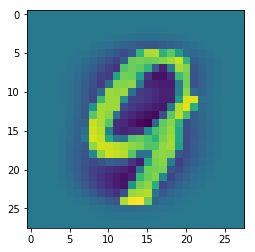

In [4]:
import matplotlib.pyplot as plt
import random

n = random.randint(0, len(valid_dataset))

image = valid_dataset[n] #mnist.train.next_batch(1)
print("Number: {}".format(valid_labels[n]))

plt.imshow(image.reshape(28, 28))

plt.show()

## Evaluate Class Distribution:

An important step when dealing with any sort of classification is to ensure that our data is relatively uniform across classes. We can visualize the class distribution using a histogram provided my the matplotlib module. You can see that the labels are actually not uniformly distributed, and we could prune the labels if we so desired.

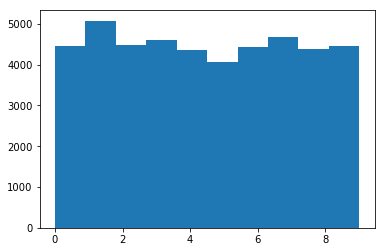

In [5]:
import matplotlib.pyplot as plt

plt.hist(train_labels)
plt.show()

## Utilities:

These are utilities for processing the data and handling the process of training the model.

### One-hot encode labels:

We can use a very concise but somewhat sophisticated script to one-hot encode the labels. The inner statement in parenthesis uses Numpy broadcasting to convert the arange array, with shape `(10, )`, into an array of shape `(10, len(labels))`, and the labels array, with shape `(len(labels),)`, into an array with shape `(len(labels), 1)`. The `[:,None]` syntax creates a new axis with length 1. The two arrays are then compared elementwise, returning a boolean array which is `True` in the desired position. We then cast the boolean values as integers, to get our one-hot encoded labels.

In [6]:
def encode_labels(labels):
    return (np.arange(10) == labels[:,None]).astype(np.uint8)

In [7]:
train_labels_encoded = encode_labels(train_labels)
valid_labels_encoded = encode_labels(valid_labels)

print("Label: ", train_labels[2], "Encoded label: ", train_labels_encoded[2])

Label:  3 Encoded label:  [0 0 0 1 0 0 0 0 0 0]


### Generate batches from preprocessed data:

This is pretty self explanatory. Given a dataset and the corresponding labels, it generates a random set of examples of the desired size.

In [8]:
def next_batch(dataset, labels, batch_size):
    indices = random.sample(range(len(dataset)), batch_size)
    batch_data = dataset[indices]
    batch_labels = labels[indices].reshape(batch_size,10)
    return batch_data, batch_labels

### Evaluate validation accuracy:

The importance of a validation set in training neural networks cannot be overstated. Think about a trendline: high correlation with a linear trendline is statistically significant, but if you make the fit more and more elaborate, it's less and less meaningful. **It's easy to overfit data**, and a validation set which evaluates the accuracy impartially is essential. You can cut off training when validation accuracy stops improving, and use that information to make better models.

This function evaluates the percent accuracy for a batch of a given size from the validation set.

In [9]:
def evaluate(size):
    images_valid, labels_valid = next_batch(valid_dataset, valid_labels_encoded, size)
    percent = model.evaluate(images_valid.reshape(size, vsize, hsize, num_channels), labels_valid)[1]*100
    print("Your model is {} percent accurate!".format(percent))

## Model Setup:

We begin the training process by importing the relevant layers and activations from Keras. In Keras, the Sequential API is designed to be easy to use with linear neural networks, which most simple convolution networks are. However, more complicated networks, like the Google Inception architecture, are not at all sequential, and the functional API is more appropriate there. There are four models below, and you are welcome to run each of them, or only one at a time.

In [10]:
from keras.models import Sequential
from keras.layers import Dense, Activation, BatchNormalization, Conv2DTranspose, Reshape, Flatten, Conv2D, Dropout, GlobalAveragePooling2D
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras.layers.advanced_activations import LeakyReLU
from keras.initializers import TruncatedNormal

import keras
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

image_size = [28, 28, 1]

batch_size = 32

vsize = image_size[0]
hsize = image_size[1]
num_channels = image_size[2]

Using TensorFlow backend.


## Simple Fully Connected Model

The simplest MNIST models use a series of fully connected layers to make predictions. These fully connected layers are just large matrix multiplications applied to the entire image, followed by non-linear activations. They are easy to use and their derivatives are simple, making them a good place to start.

In [174]:
model = Sequential()

model.add(Flatten(input_shape=(vsize, hsize, num_channels)))
model.add(Dense(512))
model.add(Activation('relu')) # we can also specify the activation in the previous layer, i.e. Dense(512, activation='relu')
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('softmax'))

Now we need to specify the optimizer which Keras will use to train the model. We will use the classic Stochastic Gradient Descent optimizer, including a momentum parameter and using Nesterov predictive momentum. More information on these optimizers can be found in [this](http://ruder.io/optimizing-gradient-descent/index.html#adam) excellent guide. We compile the model, and use the summary method show the number of parameters in each layer.

In [175]:
optimizer = RMSprop(lr=0.0001, clipvalue=1.0, decay=3e-8)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.summary() # this will list the layers and number of parameters for each

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 512)               401920    
_________________________________________________________________
activation_21 (Activation)   (None, 512)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 256)               131328    
_________________________________________________________________
activation_22 (Activation)   (None, 256)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 64)                16448     
_________________________________________________________________
activation_23 (Activation)   (None, 64)                0         
__________

## Train Model

Here we actually train the model. For additional control, we perform this step manually, batch by batch.

In [177]:
num_steps = 5000

for i in range(num_steps):
    if i % 1000 == 0:
        print("Iter: ", i)
        evaluate(batch_size)
        print('\n')
    
    images_train, labels_train = next_batch(train_dataset, train_labels_encoded, batch_size)

    loss = model.train_on_batch(images_train.reshape(batch_size, vsize, hsize, num_channels), labels_train) 
    
    if i % 200 == 0:
        print("model loss is ", loss[0])   

Iter:  0
32/32 [==============================] - 0s
Your model is 96.875 percent accurate!


model loss is  0.0216376
model loss is  0.113933
model loss is  0.00380781
model loss is  0.0137464
model loss is  0.00420753
Iter:  1000
32/32 [==============================] - 0s
Your model is 96.875 percent accurate!


model loss is  0.108884
model loss is  0.02225
model loss is  0.00289289
model loss is  0.0172207
model loss is  0.0300012
Iter:  2000
32/32 [==============================] - 0s
Your model is 100.0 percent accurate!


model loss is  0.12044
model loss is  0.0326128


KeyboardInterrupt: 

That worked pretty well. But let's try something different. **Before continuing, please continue down to the "Evaluate Model" header if you want to make predictions for this model on a test dataset, like the Kaggle MNIST competition**.

## Small convolution model

This is a small convolution model, which can be trained in a matter of minutes. This model uses a series of convolution layers, followed by ReLU activations, and Dropout to prevent overfitting. In the final step, GlobalAveragePooling is used, which takes the average of each layer, turning a spatially-large vector into a `1x1xn` prediction.

Convolution networks are a more natural way of dealing with image classification than fully connected networks, because they preserve spatial information about the input image. GlobalAveragePooling also has the advantage of preserving information separated out by the feature map, and encouraging the network to produce a feature map that describes the image. Convolution layers are also much smaller than fully connected layers, since they're only connected to a small region of the image at a time, and share weights across the whole image. Look how much more complex this network looks, even though it uses about a fifth as many parameters.

In [178]:
model = Sequential()

model.add(Conv2D(1, 3, strides=1, padding = 'same', input_shape=(vsize, hsize, num_channels))) # for visualization
model.add(LeakyReLU(0.2))

model.add(Conv2D(28, 1, strides=1, padding = 'same'))
model.add(LeakyReLU(0.2))
model.add(Conv2D(28, 3, strides=1, padding = 'same'))
model.add(LeakyReLU(0.2))
model.add(Conv2D(28, 3, strides=2, padding = 'same'))
model.add(LeakyReLU(0.2))

model.add(Dropout(0.5))

model.add(Conv2D(56, 3, strides=1, padding = 'same'))
model.add(LeakyReLU(0.2))
model.add(Conv2D(56, 3, strides=1, padding = 'same'))
model.add(LeakyReLU(0.2))
model.add(Conv2D(56, 3, strides=2, padding = 'same'))
model.add(LeakyReLU(0.2))

model.add(Dropout(0.5))

model.add(Conv2D(56, 3, strides=1, padding = 'same'))
model.add(LeakyReLU(0.2))
model.add(Conv2D(56, 1, strides=1, padding = 'same'))
model.add(LeakyReLU(0.2))
model.add(Conv2D(10, 1, strides=2, padding = 'same'))
model.add(LeakyReLU(0.2))

model.add(GlobalAveragePooling2D())

model.add(Activation('softmax'))

optimizer = Adam(lr=0.0002) # here we use the Adam optimizer, a more elaborate cousin of SGD

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 1)         10        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 28)        56        
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 28, 28, 28)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 28)        7084      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 28, 28, 28)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 28)        7084      
__________

## Train Model

Here we actually train the model. For additional control, we perform this step manually, batch by batch. Note that while this model uses fewer parameters than the fully connected model, it takes much longer to train, since backpropogation is much more complicated

In [180]:
num_steps = 5000

for i in range(num_steps):
    if i % 500 == 0:
        print("Iter: ", i)
        evaluate(batch_size)
        print('\n')
    
    images_train, labels_train = next_batch(train_dataset, train_labels_encoded, batch_size)

    loss = model.train_on_batch(images_train.reshape(batch_size, vsize, hsize, num_channels), labels_train) 
    
    if i % 200 == 0:
        print("model loss is ", loss[0])

Iter:  0
32/32 [==============================] - 0s
Your model is 3.125 percent accurate!


model loss is  2.30261
model loss is  1.4226
model loss is  1.0183
model loss is  0.709499
model loss is  0.661462
Iter:  1000
32/32 [==============================] - 0s
Your model is 75.0 percent accurate!


model loss is  0.436884
model loss is  0.612463
model loss is  0.513328
model loss is  0.433636
model loss is  0.280018
Iter:  2000
32/32 [==============================] - 0s
Your model is 96.875 percent accurate!


model loss is  0.326926
model loss is  0.525506
model loss is  0.577065
model loss is  0.518575
model loss is  0.530569
Iter:  3000
32/32 [==============================] - 0s
Your model is 90.625 percent accurate!


model loss is  0.163107
model loss is  0.142122
model loss is  0.151462
model loss is  0.173525
model loss is  0.0709266
Iter:  4000
32/32 [==============================] - 0s
Your model is 96.875 percent accurate!


model loss is  0.359121
model loss is  0.3398

## Large convolution model

This is a much larger convolution model, and it may take a while to train on a CPU. The structure is mostly the same, except the hidden layers are deeper.

In [13]:
model = Sequential()

model.add(Conv2D(1, 3, strides=1, padding = 'same', input_shape=(vsize, hsize, num_channels))) # for visualization
model.add(LeakyReLU(0.2))

model.add(Conv2D(84, 1, strides=1, padding = 'same'))
model.add(LeakyReLU(0.2))
model.add(Conv2D(84, 3, strides=1, padding = 'same'))
model.add(LeakyReLU(0.2))
model.add(Conv2D(84, 3, strides=2, padding = 'same'))
model.add(LeakyReLU(0.2))

model.add(Dropout(0.3))

model.add(Conv2D(168, 3, strides=1, padding = 'same'))
model.add(LeakyReLU(0.2))
model.add(Conv2D(168, 3, strides=1, padding = 'same'))
model.add(LeakyReLU(0.2))
model.add(Conv2D(168, 3, strides=2, padding = 'same'))
model.add(LeakyReLU(0.2))

model.add(Dropout(0.4))

model.add(Conv2D(168, 3, strides=1, padding = 'same'))
model.add(LeakyReLU(0.2))
model.add(Conv2D(168, 1, strides=1, padding = 'same'))
model.add(LeakyReLU(0.2))
model.add(Conv2D(10, 1, strides=2, padding = 'same'))
model.add(LeakyReLU(0.2))

model.add(GlobalAveragePooling2D())

model.add(Activation('softmax'))

optimizer = Adam(lr=0.0002) # here we use the Adam optimizer, a more elaborate cousin of SGD

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 28, 28, 1)         10        
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 28, 28, 84)        168       
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 28, 28, 84)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 28, 28, 84)        63588     
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 28, 28, 84)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 14, 14, 84)        63588     
__________

## Train Model

Here we actually train the model. For additional control, we perform this step manually, batch by batch.

In [14]:
num_steps = 3000

for i in range(num_steps):
    if i % 1000 == 0:
        print("Iter: ", i)
        evaluate(batch_size)
        print('\n')
    
    images_train, labels_train = next_batch(train_dataset, train_labels_encoded, batch_size)

    loss = model.train_on_batch(images_train.reshape(batch_size, vsize, hsize, num_channels), labels_train) 
    
    if i % 200 == 0:
        print("model loss is ", loss[0])

Iter:  0
32/32 [==============================] - 0s
Your model is 18.75 percent accurate!


model loss is  2.30287
model loss is  0.790993
model loss is  0.349134
model loss is  0.454545
model loss is  0.196152
Iter:  1000
32/32 [==============================] - 0s
Your model is 93.75 percent accurate!


model loss is  0.155478
model loss is  0.371035
model loss is  0.635919
model loss is  0.025465
model loss is  0.191232
Iter:  2000
32/32 [==============================] - 0s
Your model is 100.0 percent accurate!


model loss is  0.0811365
model loss is  0.117066
model loss is  0.246956
model loss is  0.0768135
model loss is  0.238888


## Evaluate Model

Now that we've seen all three models in action, let's make some actual predictions. Here, you can load test data and save predictions for the classic [Kaggle competition](https://www.kaggle.com/c/digit-recognizer/data). If you want to participate in the Kaggle challenge with any of these datasets, please go to the link and save the test.csv file to the cloned directory. You can also use other test datasets here instead, if you want.

First, we'll evaluate the accuracy of our model:

In [15]:
evaluate(5000)

5000/5000 [==============================] - 28s    
Your model is 96.92 percent accurate!


### Load test dataset from CSV

If you aren't using the Kaggle dataset, just skip this step and load your own in a new cell.

In [ ]:
import numpy as np

test = np.genfromtxt('test.csv', delimiter=",", dtype=int)[1:,:].reshape(len(test), 28, 28, 1)

test_dataset = test - np.mean(test, axis=0)

print("Mean: %f, Std: %f" % (np.mean(test_dataset), np.std(test_dataset)))

### Generate Predictions for Test Dataset

This may take a while.

In [110]:
predictions = model.predict(test_dataet)

### Save predictions to file:

This function will save your images to a csv file in the correct format for submission to the Kaggle competition.

In [51]:
def save_to_file(data, name):
    index = np.linspace(1,len(data),len(data))
    data = np.argmax(data, axis=1)
    with open('{}.csv'.format(name), 'w') as csvfile:
        writer = csv.writer(csvfile, delimiter=',')
        writer.writerow(['ImageId', 'Label'])
        for i in range(len(data)):
            writer.writerow([index[i].astype(np.uint32), data[i]])

In [117]:
save_to_file(predictions, "MNIST_predictions")

## Save model to file

If you'd like to save the current model for future use, run this script. To save multiple models, change the file name.

In [24]:
model.save('saved_models/MNIST_model_2.h5')

## Load pre-trained version of the model

Keras allows us to load and save entire models, so running this command will load a pretrained model which you can continue training or use for testing purposes. I have included a pre-trained model in the github repository, but you can use your own models for the next step if you so desire. However, this is only compatible with the third model, so you may wish to load the pre-trained model here, or modify the following code to work with any model.

In [27]:
from keras.models import load_model 

model = load_model('saved_models/MNIST_model.h5')

## Hidden Layer Visualization

Before you proceed, make sure you have run one of the second two models most recently, or load one of those models above. We will be viewing hidden layers in the MNIST networks, which will tell us something about how the network is parsing the information.

Our first step is to create a new network, with just a single layer identical to the first layer in the convolution networks above. We initialize the layer with weights from the above network, and view that output next to the corresponding input.

In [28]:
visualization = Sequential()
visualization.add(Conv2D(1, 3, strides=1, padding = 'same', input_shape=(vsize, hsize, num_channels), weights=model.layers[0].get_weights())) # for visualization

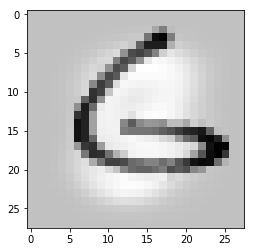

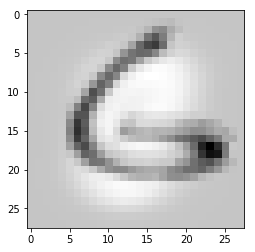

KeyboardInterrupt: 

In [29]:
import time
from IPython.display import clear_output

hidden_output = visualization.predict(train_dataset.reshape(len(train_dataset),vsize, hsize, num_channels))

while True:
    n = random.randint(0, len(train_dataset))
    plt.imshow(train_dataset[n].reshape(vsize, hsize), cmap='Greys')
    plt.show()
    plt.imshow(hidden_output[n].reshape(vsize, hsize), cmap='Greys')
    plt.show()
    time.sleep(1)
    clear_output(wait=True)

Now we will view some of the deeper layers, although they will be less informative overall. **Note: this is designed to work with the second model. Please run that model, or change the depth of the second layer to 84**

In [53]:
visualization2 = Sequential()

visualization2.add(Conv2D(1, 3, strides=1, padding = 'same', input_shape=(vsize, hsize, num_channels), weights=model.layers[0].get_weights())) # for visualization
model.add(LeakyReLU(0.2))

visualization2.add(Conv2D(84, 1, strides=1, padding = 'same', weights=model.layers[2].get_weights()))

visualization2.add(Conv2D(84, 3, strides=1, padding = 'same', weights=model.layers[4].get_weights()))

hidden_output = visualization2.predict(train_dataset[0:20].reshape(20,vsize, hsize, num_channels))

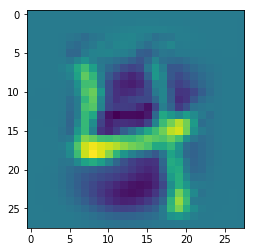

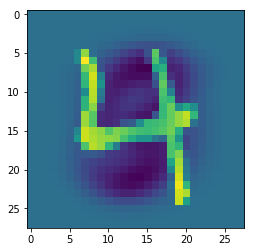

In [75]:
import random

n = random.randint(0, 19) # which image
m = random.randint(0, 83) #which layer

plt.imshow(hidden_output[n,:,:,m])
plt.show()

plt.imshow(train_dataset[n].reshape(28, 28))
plt.show()

This is fascinating, although not that enlightening. Stil it's nice to see something of what's going on. For more information about visualization techniques, check out [this paper](https://arxiv.org/pdf/1311.2901.pdf). We can go another layer deeper, after the image has been downsampled, and see how it sumarizes information.

In [91]:
visualization3 = Sequential()

visualization3.add(Conv2D(1, 3, strides=1, padding = 'same', input_shape=(vsize, hsize, num_channels), weights=model.layers[0].get_weights())) # for visualization
model.add(LeakyReLU(0.2))

visualization3.add(Conv2D(84, 1, strides=1, padding = 'same', weights=model.layers[2].get_weights()))

visualization3.add(Conv2D(84, 3, strides=1, padding = 'same', weights=model.layers[4].get_weights()))

visualization3.add(Conv2D(84, 3, strides=2, padding = 'same', weights=model.layers[6].get_weights()))

hidden_output = visualization3.predict(train_dataset[0:20].reshape(20,vsize, hsize, num_channels))

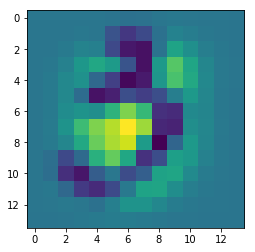

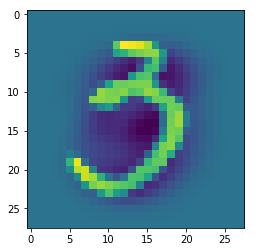

In [105]:
import random

n = random.randint(0, 19) # which image
m = random.randint(0, 83) #which layer

plt.imshow(hidden_output[n,:,:,m])
plt.show()

plt.imshow(train_dataset[n].reshape(28, 28))
plt.show()

## Conclusion:

I hope this was useful, and helped you better understand how to implement convolution neural networks. Please let me know if you have any comments or ways of improving the notebook.